# IMPORTS

## Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data

In [2]:
from novelty_detection.data import load_data
data = load_data("banknote_authentication.txt", header_names=['x1', 'x2', 'x3', 'x4', 'y'])
print(data.shape)
data.head()

(1372, 5)


,x1,x2,x3,x4,y
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# PREPROCESSING

In [3]:
X=data[['x1', 'x2', 'x3', 'x4']].to_numpy()
y=data[['y']].to_numpy()

## Split

In [4]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
print('x train shape: ', train_x.shape)
print('y train shape: ', train_y.shape) 
print('x test shape: ', test_x.shape)
print('x test shape: ', test_y.shape)

x train shape:  (1097, 4)
y train shape:  (1097, 1)
x test shape:  (275, 4)
x test shape:  (275, 1)


## Scale

In [5]:
from novelty_detection.preprocessing import minmax_scaler, std_scaler
train_x_norm = minmax_scaler(train_x)
test_x_norm = minmax_scaler(test_x)
X_norm = minmax_scaler(X)

# TRAINING

In [6]:
from novelty_detection.som import SOM

model=SOM(som_grid_size=(10,10),
          max_distance=4,
          learning_rate_0=0.5,
          max_iter=70000,
          random_state=40,
          methods={'init_som': 'uniform',
                    'bmu_distance': 'cityblock',
                    'compute_neighborhood': 'ceil',
                    'update_sigma_and_learning_rate': 'linear'})

model=model.fit(train_x_norm)
som=model.som
som_dataset=som.reshape(-1,som.shape[2])

# NOVELTY DETECTION

## Quantization error novelty detector

Compute dmax as the worst case sceneario (among all the min distances between the training data and the neurons, dmax is the max of those min distances)

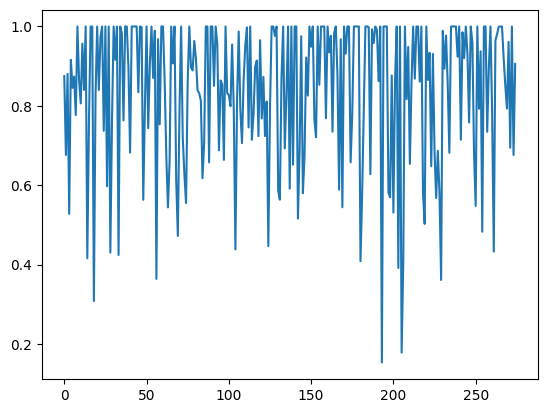

In [7]:
from novelty_detection.som_novelty_detectors import Quantization_Error
model1=Quantization_Error(som, 'worst')
metric_eq1=model1.evaluate(train_x_norm, test_x_norm)
plt.plot(np.arange(test_x_norm.shape[0]), metric_eq1)

Compute dmax as the worst case sceneario by neuron (each neuron that has been hit has one or more min distances associated, and for each neuron we store the maximum of those min distances)

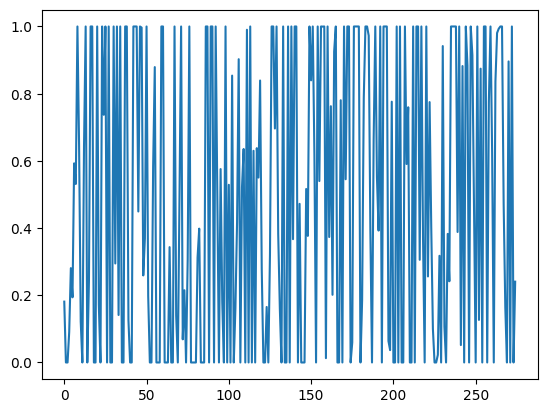

In [8]:
model2=Quantization_Error(som, 'by_bmu')
metric_eq2=model2.evaluate(train_x_norm, test_x_norm)
plt.plot(np.arange(test_x_norm.shape[0]), metric_eq2)

Compare both methods (ideally they should be in a 45º line)

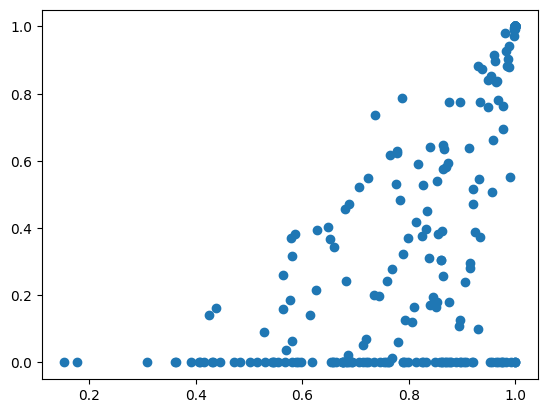

In [9]:
plt.scatter(metric_eq1, metric_eq2)

In [10]:
import pandas as pd

dmax_map = model2.dmax_map
freq_map = model2.freq_map

df_dmax_map = pd.DataFrame(dmax_map)
df_dmax_map=(df_dmax_map
            .style
            .background_gradient(cmap='coolwarm', axis=None, vmin=0, vmax=np.nanmax(dmax_map))
            .highlight_null(color='yellow')  # Color NaNs grey
            .format(precision=3))

df_freq_map = pd.DataFrame(freq_map)
df_freq_map=(df_freq_map
            .style
            .background_gradient(cmap='coolwarm', axis=None, vmin=0, vmax=np.nanmax(freq_map))
            .highlight_null(color='yellow')  # Color NaNs grey
            .format(precision=0))

In [11]:
df_dmax_map

,0,1,2,3,4,5,6,7,8,9
0,0.097,0.156,0.123,0.112,nan,0.188,0.097,0.131,0.154,0.193
1,0.110,0.104,0.118,0.123,0.160,nan,0.192,0.119,0.155,0.144
2,0.098,0.110,0.110,0.138,0.181,0.066,0.110,0.125,0.068,0.135
3,0.115,0.102,0.063,0.096,0.049,0.137,0.130,0.074,0.145,0.180
4,0.135,0.066,0.073,0.088,0.093,0.136,0.070,0.088,0.069,0.078
5,0.166,0.084,0.086,0.147,nan,0.116,0.070,0.092,0.077,0.107
6,0.101,0.081,0.113,0.133,0.104,0.090,0.066,0.072,0.076,0.268
7,0.066,0.095,0.117,0.129,0.125,0.135,0.104,0.065,0.083,0.190
8,0.160,0.087,0.102,0.070,0.180,0.095,0.127,nan,0.093,0.204
9,0.118,0.097,0.097,0.082,0.130,0.174,0.170,0.184,0.108,0.162


In [12]:
df_freq_map

,0,1,2,3,4,5,6,7,8,9
0,11,19,11,13,0,19,1,22,4,20
1,26,7,8,8,11,0,16,11,9,7
2,7,15,7,12,9,3,18,17,7,19
3,23,13,8,7,1,14,10,11,26,1
4,11,14,13,10,9,14,14,14,9,11
5,11,11,9,19,0,13,13,15,19,11
6,13,12,11,9,9,7,8,11,11,10
7,11,13,12,10,17,7,15,14,9,6
8,11,9,8,7,7,1,7,0,9,9
9,29,13,10,6,14,15,12,7,7,10


Check the corresponding neuron of the data that has been set to zero

In [13]:
def highlight_greater_than_zero(val):
    color = 'background-color: lightcoral' if val > 0 else ''
    return color

anomalies = test_x_norm[metric_eq2==0]
freq_map_anomalies = model2.find_bmu_counts(anomalies, model2.som)

df_freq_map_anomalies = pd.DataFrame(freq_map_anomalies)
df_freq_map_anomalies=(df_freq_map_anomalies
            .style
            .applymap(highlight_greater_than_zero)
            .highlight_null(color='yellow')  # Color NaNs grey
            .format(precision=0))
df_freq_map_anomalies

C:\Users\edu12\AppData\Local\Temp\ipykernel_8908\2765431940.py:11: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_greater_than_zero)


,0,1,2,3,4,5,6,7,8,9
0,2,1,1,0,0,0,0,0,0,1
1,2,0,2,1,1,0,0,1,1,0
2,1,0,0,0,0,2,1,1,0,0
3,0,0,2,1,1,0,1,0,0,0
4,0,1,2,0,1,0,0,0,1,2
5,0,0,0,0,0,3,3,0,0,0
6,1,0,0,0,0,0,1,2,1,0
7,6,0,1,1,0,4,2,1,1,0
8,0,0,2,0,0,1,5,0,0,0
9,5,1,2,3,1,1,2,1,2,3


## TOPOGRAPHIC ERROR

In [14]:
model2.topographic_error(train_x_norm, model2.som)

0.02187784867821331